# importing libraries and packages

In [6]:
from __future__ import division

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import datetime, warnings
import matplotlib.cm as cm
import itertools
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline


# Reading our dataset

In [8]:
import os

# Check if online_retail.csv exists, if not create sample data
if not os.path.exists('online_retail.csv'):
    print("Creating sample dataset...")
    # Create sample retail data for demonstration
    import random
    from datetime import datetime, timedelta
    
    countries = ['France', 'UK', 'Germany', 'Netherlands', 'EIRE', 'Belgium', 'Switzerland', 'Sweden', 'Norway', 'Italy']
    descriptions = ['WHITE HANGING HEART T-LIGHT HOLDER', 'RED WOOLLY HOTTIE WHITE HEART', 'CREAM CUPID HEARTS COAT HANGER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'HAND WARMER UNION JACK', 'BLUE SKITTLE GIFTBOX', 'RECIPE BOX WITH METAL LID']
    
    data = []
    base_date = datetime(2010, 12, 1)
    
    for i in range(5000):
        invoice_no = str(536365 + i // 20)
        stock_code = str(85123 + random.randint(0, 100))
        description = random.choice(descriptions)
        quantity = random.randint(1, 50)
        invoice_date = base_date + timedelta(days=random.randint(0, 300))
        unit_price = round(random.uniform(0.85, 15.0), 2)
        customer_id = 17850 + random.randint(0, 500)
        country = random.choice(countries)
        
        data.append({
            'InvoiceNo': invoice_no,
            'StockCode': stock_code,
            'Description': description,
            'Quantity': quantity,
            'InvoiceDate': invoice_date.strftime('%d/%m/%Y %H:%M'),
            'UnitPrice': unit_price,
            'CustomerID': customer_id,
            'Country': country
        })
    
    retail_initial = pd.DataFrame(data)
    retail_initial.to_csv('online_retail.csv', index=False)
    print("Sample dataset created!")
else:
    retail_initial = pd.read_csv('online_retail.csv')


Creating sample dataset...
Sample dataset created!


In [9]:
retail_initial

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85213,WHITE HANGING HEART T-LIGHT HOLDER,8,12/07/2011 00:00,8.82,18112,Sweden
1,536365,85145,RED WOOLLY HOTTIE WHITE HEART,42,12/09/2011 00:00,6.51,17890,Switzerland
2,536365,85153,CREAM CUPID HEARTS COAT HANGER,34,27/02/2011 00:00,3.26,18103,Italy
3,536365,85133,CREAM CUPID HEARTS COAT HANGER,21,01/07/2011 00:00,4.96,18034,EIRE
4,536365,85205,KNITTED UNION FLAG HOT WATER BOTTLE,44,10/01/2011 00:00,9.71,18264,France
...,...,...,...,...,...,...,...,...
4995,536614,85128,WHITE HANGING HEART T-LIGHT HOLDER,17,29/08/2011 00:00,14.35,18196,Norway
4996,536614,85154,KNITTED UNION FLAG HOT WATER BOTTLE,17,04/06/2011 00:00,14.10,18073,Italy
4997,536614,85222,HAND WARMER UNION JACK,11,10/03/2011 00:00,10.50,18213,Sweden
4998,536614,85158,HAND WARMER UNION JACK,28,03/09/2011 00:00,10.48,18218,UK


# Exploratory Data Analysis

In [10]:
retail_initial.describe()

,Quantity,UnitPrice,CustomerID
count,5000.000000,5000.000000,5000.00000
mean,25.467600,7.939426,18100.86080
std,14.438291,4.103576,145.08687
min,1.000000,0.850000,17850.00000
25%,13.000000,4.370000,17974.00000
50%,25.000000,7.975000,18103.50000
75%,38.000000,11.502500,18227.00000
max,50.000000,15.000000,18350.00000


In [11]:
retail_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85213,WHITE HANGING HEART T-LIGHT HOLDER,8,12/07/2011 00:00,8.82,18112,Sweden
1,536365,85145,RED WOOLLY HOTTIE WHITE HEART,42,12/09/2011 00:00,6.51,17890,Switzerland
2,536365,85153,CREAM CUPID HEARTS COAT HANGER,34,27/02/2011 00:00,3.26,18103,Italy
3,536365,85133,CREAM CUPID HEARTS COAT HANGER,21,01/07/2011 00:00,4.96,18034,EIRE
4,536365,85205,KNITTED UNION FLAG HOT WATER BOTTLE,44,10/01/2011 00:00,9.71,18264,France


In [12]:
retail_initial.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4995,536614,85128,WHITE HANGING HEART T-LIGHT HOLDER,17,29/08/2011 00:00,14.35,18196,Norway
4996,536614,85154,KNITTED UNION FLAG HOT WATER BOTTLE,17,04/06/2011 00:00,14.10,18073,Italy
4997,536614,85222,HAND WARMER UNION JACK,11,10/03/2011 00:00,10.50,18213,Sweden
4998,536614,85158,HAND WARMER UNION JACK,28,03/09/2011 00:00,10.48,18218,UK
4999,536614,85200,RECIPE BOX WITH METAL LID,8,16/12/2010 00:00,13.48,18110,Switzerland


In [13]:
print('number of rows :\n',retail_initial.count())

number of rows :
 InvoiceNo      5000
StockCode      5000
Description    5000
Quantity       5000
InvoiceDate    5000
UnitPrice      5000
CustomerID     5000
Country        5000
dtype: int64


In [14]:
print('dimensions:',retail_initial.shape)

dimensions: (5000, 8)


In [15]:
retail_initial.info()
#info shows us memory requirements

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    5000 non-null   object 
 1   StockCode    5000 non-null   object 
 2   Description  5000 non-null   object 
 3   Quantity     5000 non-null   int64  
 4   InvoiceDate  5000 non-null   object 
 5   UnitPrice    5000 non-null   float64
 6   CustomerID   5000 non-null   int64  
 7   Country      5000 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 312.6+ KB


In [19]:
retail_initial['InvoiceDate'] = pd.to_datetime(retail_initial['InvoiceDate'], format='%d/%m/%Y %H:%M')
retail_initial['InvoiceDate']


0      2011-07-12
1      2011-09-12
2      2011-02-27
3      2011-07-01
4      2011-01-10
          ...    
4995   2011-08-29
4996   2011-06-04
4997   2011-03-10
4998   2011-09-03
4999   2010-12-16
Name: InvoiceDate, Length: 5000, dtype: datetime64[ns]

# finding null values

In [17]:
retail_initial.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
## We can see here that the description and customerID values have null values.
##let us look into these columns to understand the category of missing data

In [18]:
retail_initial['CustomerID'].value_counts()

CustomerID
18173    22
18079    22
18291    20
18197    18
18301    18
         ..
18022     3
18014     3
18342     3
18236     3
18207     2
Name: count, Length: 501, dtype: int64

# cleaning our data

In [20]:
#Removing empty spaces in the descriptions.
retail_initial['Description'] = retail_initial['Description'].str.strip()
retail_initial

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85213,WHITE HANGING HEART T-LIGHT HOLDER,8,2011-07-12,8.82,18112,Sweden
1,536365,85145,RED WOOLLY HOTTIE WHITE HEART,42,2011-09-12,6.51,17890,Switzerland
2,536365,85153,CREAM CUPID HEARTS COAT HANGER,34,2011-02-27,3.26,18103,Italy
3,536365,85133,CREAM CUPID HEARTS COAT HANGER,21,2011-07-01,4.96,18034,EIRE
4,536365,85205,KNITTED UNION FLAG HOT WATER BOTTLE,44,2011-01-10,9.71,18264,France
...,...,...,...,...,...,...,...,...
4995,536614,85128,WHITE HANGING HEART T-LIGHT HOLDER,17,2011-08-29,14.35,18196,Norway
4996,536614,85154,KNITTED UNION FLAG HOT WATER BOTTLE,17,2011-06-04,14.10,18073,Italy
4997,536614,85222,HAND WARMER UNION JACK,11,2011-03-10,10.50,18213,Sweden
4998,536614,85158,HAND WARMER UNION JACK,28,2011-09-03,10.48,18218,UK


In [21]:
retail_initial.dropna(axis = 0, subset= 'InvoiceNo',inplace = True)
#Converting the InvoiceNo to a String
retail_initial['InvoiceNo'] = retail_initial['InvoiceNo'].astype(str)
#Dropping rows in InvoiceNo which contains ‘C’ as it denotes a Cancelled order
retail_initial

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85213,WHITE HANGING HEART T-LIGHT HOLDER,8,2011-07-12,8.82,18112,Sweden
1,536365,85145,RED WOOLLY HOTTIE WHITE HEART,42,2011-09-12,6.51,17890,Switzerland
2,536365,85153,CREAM CUPID HEARTS COAT HANGER,34,2011-02-27,3.26,18103,Italy
3,536365,85133,CREAM CUPID HEARTS COAT HANGER,21,2011-07-01,4.96,18034,EIRE
4,536365,85205,KNITTED UNION FLAG HOT WATER BOTTLE,44,2011-01-10,9.71,18264,France
...,...,...,...,...,...,...,...,...
4995,536614,85128,WHITE HANGING HEART T-LIGHT HOLDER,17,2011-08-29,14.35,18196,Norway
4996,536614,85154,KNITTED UNION FLAG HOT WATER BOTTLE,17,2011-06-04,14.10,18073,Italy
4997,536614,85222,HAND WARMER UNION JACK,11,2011-03-10,10.50,18213,Sweden
4998,536614,85158,HAND WARMER UNION JACK,28,2011-09-03,10.48,18218,UK


In [16]:
##4372 data entries are not mapped to any customer, thus lack ID, we shall delete them as they are useless

In [22]:
retail_initial.dropna(axis=0,subset = 'CustomerID',inplace = True)
retail_initial

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85213,WHITE HANGING HEART T-LIGHT HOLDER,8,2011-07-12,8.82,18112,Sweden
1,536365,85145,RED WOOLLY HOTTIE WHITE HEART,42,2011-09-12,6.51,17890,Switzerland
2,536365,85153,CREAM CUPID HEARTS COAT HANGER,34,2011-02-27,3.26,18103,Italy
3,536365,85133,CREAM CUPID HEARTS COAT HANGER,21,2011-07-01,4.96,18034,EIRE
4,536365,85205,KNITTED UNION FLAG HOT WATER BOTTLE,44,2011-01-10,9.71,18264,France
...,...,...,...,...,...,...,...,...
4995,536614,85128,WHITE HANGING HEART T-LIGHT HOLDER,17,2011-08-29,14.35,18196,Norway
4996,536614,85154,KNITTED UNION FLAG HOT WATER BOTTLE,17,2011-06-04,14.10,18073,Italy
4997,536614,85222,HAND WARMER UNION JACK,11,2011-03-10,10.50,18213,Sweden
4998,536614,85158,HAND WARMER UNION JACK,28,2011-09-03,10.48,18218,UK


In [23]:
retail_initial.shape

(5000, 8)

In [19]:
### the data entries have been reduced to 4,06,829
###further let us remove the duplicate values

In [24]:
print('Duplicate data entries removed: {}'.format(retail_initial.duplicated().sum()))
retail_initial.drop_duplicates(inplace = True)

Duplicate data entries removed: 0


In [25]:
retail_initial.shape

(5000, 8)

# correlation between values 

<Axes: >

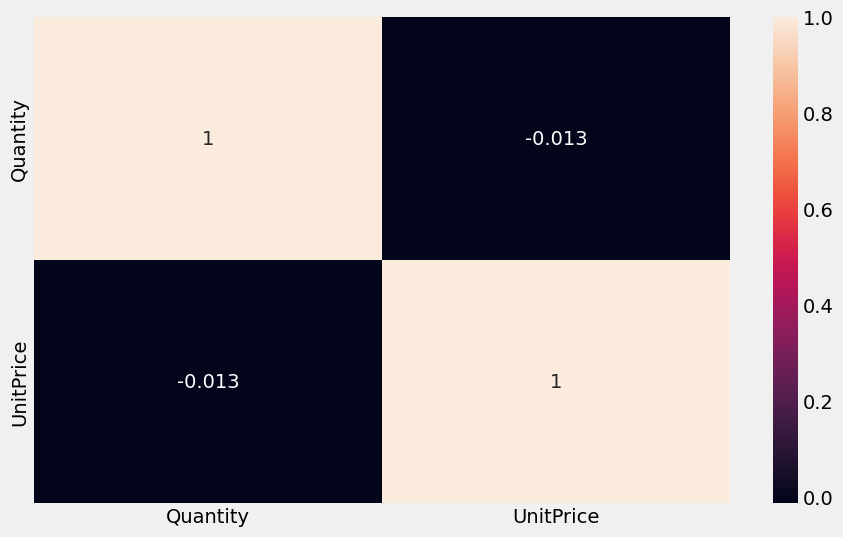

In [26]:
plt.figure(figsize = (10,6))
corr_matrix = retail_initial[['Quantity', 'UnitPrice']].corr()
sns.heatmap(corr_matrix, annot=True)


In [23]:
#from the heatmap we find that,
#quantity is innversely dependent on unitprice as correlation is negative

# Feature engineering
Feature engineering is the process of transforming raw data into features that are suitable for machine learning models.

In [24]:
#let us check if dataset is balanced or imbalanced

In [27]:
retail_initial.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [26]:
countries = pd.Series(retail_initial['Country'].unique())

In [28]:
orders_per_country = retail_initial[['CustomerID','Country']].groupby(['Country']).count()
orders_per_country.reset_index(drop = False)
orders_per_country = orders_per_country.sort_values(by='CustomerID', ascending=False)
orders_per_country 

,CustomerID
Country,
Belgium,535
UK,528
Germany,516
EIRE,512
Norway,511
Italy,510
France,493
Switzerland,473
Netherlands,470


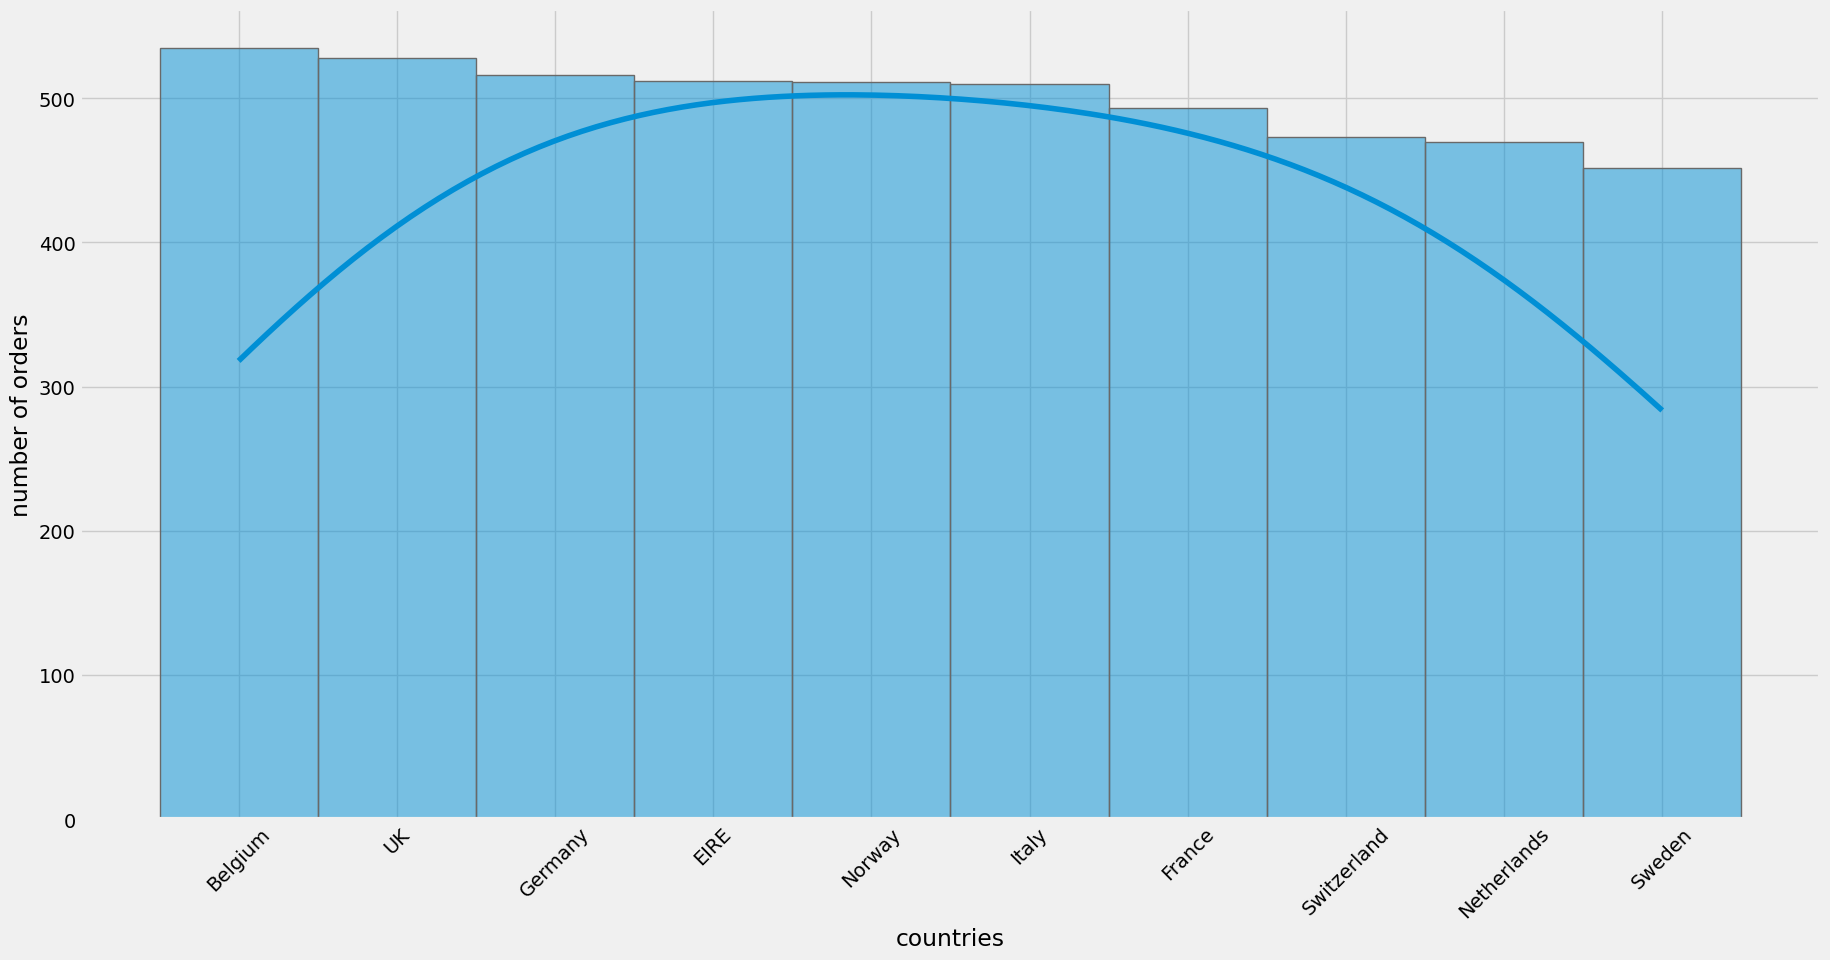

In [29]:
plt.figure(figsize=(20,10))
plt.xlabel('countries')
plt.ylabel('number of orders')
sns.histplot(data=orders_per_country, 
             x='Country', 
             weights='CustomerID', 
             bins=len(orders_per_country), 
             kde=True)
plt.xticks(rotation=45) 
plt.show()

In [29]:
#what we can observe is:
#there is kernal density overlay- most countries
#the graph is right-skewed:
#indicating that most countries have fewer orders while a small number have significantly higher counts (upscaling reqd)
#Outliers: There may be extreme outliers


# products and customers analysis

In [30]:
#sns.pairplot(retail_initial)

In [31]:
#product and transactions analysis

In [30]:
product_details = pd.DataFrame({'products' : len(retail_initial['StockCode'].value_counts()),
                               'Transactions': len(retail_initial['InvoiceNo'].value_counts()),
                               'Customers' : len(retail_initial['CustomerID'].value_counts())}, index = ['Quantity'])
product_details

,products,Transactions,Customers
Quantity,101,250,501


In [33]:
##there are 3684 different products which 4372 customers have purchased over 22k transactions
##let us find number of products purchased per customer visit

In [31]:
products_per_purchase= retail_initial.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_per_purchase=products_per_purchase.rename(columns= {'InvoiceDate' : 'number of products'})
products_per_purchase.sort_values('number of products')


,CustomerID,InvoiceNo,number of products
4864,18347,536516,1
1,17850,536392,1
2,17850,536408,1
3,17850,536415,1
4,17850,536416,1
...,...,...,...
3668,18226,536423,2
3983,18258,536604,2
3185,18177,536469,2
4018,18262,536383,2


In [35]:
#some customers are frequent visitors, with large number of products purchased (example: customer #6810)
#some customers have bought 1-2 products (example : customer #12809)

In [32]:
retail_cleaned = retail_initial.copy(deep = True)
retail_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  retail_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    retail_test = retail_initial[(retail_initial['CustomerID'] == col['CustomerID']) &
                         (retail_initial['StockCode']  == col['StockCode']) & 
                         (retail_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (retail_initial['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (retail_test.shape[0] == 0): 
        doubtfull_entry.append(index)
   
    # Cancelation WITH a counterpart
    elif (retail_test.shape[0] == 1): 
        index_order = retail_test.index[0]
        retail_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
   
    # Various counterparts exist in orders: we delete the last one
    elif (retail_test.shape[0] > 1): 
        retail_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in retail_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            retail_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [33]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 0
doubtfull_entry: 0


In [38]:
#this code shows us that there are 6197+2558 =  entries to remove
#entry_to_remove: 6197
#doubtfull_entry: 2558

In [39]:
#let us analyse the stockcode column
retail_initial['StockCode'].unique()

array(['85123A', '71053', '84406B', ..., '90214Z', '90089', '23843'],
      dtype=object)

In [40]:
##we see that some values contain specific letters - A,B,C,D,etc
#we will map these letters to their meaning

In [34]:
retail_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
retail_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = retail_cleaned[(retail_cleaned['Quantity'] < 0) & (retail_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


In [35]:
list_special_codes = retail_cleaned[retail_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array([], dtype=object)

In [36]:
for code in list_special_codes:
    print("{} -> {}".format(code,retail_cleaned[retail_cleaned['StockCode'] == code]['Description'].unique()[0]))

In [37]:
# now, we can create the basket data for transactions 
#The basket will contain the Qty of each items bought per transaction.
basket = retail_cleaned[retail_cleaned['Country']=='France'].groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket.tail()

Description,BLUE SKITTLE GIFTBOX,CREAM CUPID HEARTS COAT HANGER,HAND WARMER UNION JACK,KNITTED UNION FLAG HOT WATER BOTTLE,RECIPE BOX WITH METAL LID,RED WOOLLY HOTTIE WHITE HEART,WHITE HANGING HEART T-LIGHT HOLDER
InvoiceNo,,,,,,,
536610,0.0,2.0,0.0,0.0,93.0,0.0,0.0
536611,0.0,0.0,0.0,9.0,0.0,0.0,0.0
536612,10.0,0.0,0.0,0.0,0.0,3.0,44.0
536613,0.0,51.0,36.0,0.0,0.0,0.0,11.0
536614,4.0,26.0,34.0,0.0,31.0,0.0,0.0


In [38]:
# Remove items with low frequency
item_counts = basket.sum(axis=0)
frequent_items = item_counts[item_counts >= 5].index
basket_reduced = basket[frequent_items]


# Data Encoding

In [46]:
# we will use OneHotCoding technique to get the data ready to feed to the model
# we choose this technique because- nominal data

In [39]:
def encode(x):
    if x <= 0:
        return 0
    else:
        return 1
    
basket_encoded = basket.map(encode)


# Applying the apriori algorithm

In [40]:
frequent_items = apriori(basket_encoded,min_support=0.07,use_colnames=True)


In [41]:
frequent_items

,support,itemsets
0,0.299539,(BLUE SKITTLE GIFTBOX)
1,0.271889,(CREAM CUPID HEARTS COAT HANGER)
2,0.313364,(HAND WARMER UNION JACK)
3,0.239631,(KNITTED UNION FLAG HOT WATER BOTTLE)
4,0.322581,(RECIPE BOX WITH METAL LID)
5,0.258065,(RED WOOLLY HOTTIE WHITE HEART)
6,0.290323,(WHITE HANGING HEART T-LIGHT HOLDER)
7,0.087558,"(RECIPE BOX WITH METAL LID, BLUE SKITTLE GIFTBOX)"
8,0.078341,"(RED WOOLLY HOTTIE WHITE HEART, BLUE SKITTLE G..."
9,0.096774,"(HAND WARMER UNION JACK, CREAM CUPID HEARTS CO..."


# Association Rules

In [42]:
assoc_rules = pd.DataFrame(association_rules(frequent_items,metric="lift",min_threshold=1,num_itemsets=0))
assoc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


# Filtering the rules

In [43]:
filtered_assoc_rules= pd.DataFrame([(assoc_rules['lift']>=6) & (assoc_rules['confidence']>=0.8)])

In [44]:
filtered_assoc_rules

""
0


#We can understand the accuracy using the following lift vs confidence graph

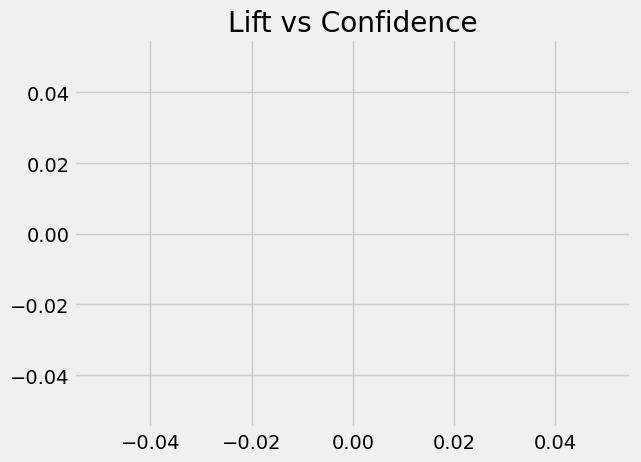

In [45]:
sns.scatterplot(x='lift', y='confidence', data=assoc_rules)
plt.title('Lift vs Confidence')
plt.show()

In [46]:
# Sort the rules by lift and show the top 10
top_rules = assoc_rules.sort_values('lift', ascending=False).head(10)
print(top_rules[['antecedents', 'consequents', 'lift']])


Empty DataFrame
Columns: [antecedents, consequents, lift]
Index: []


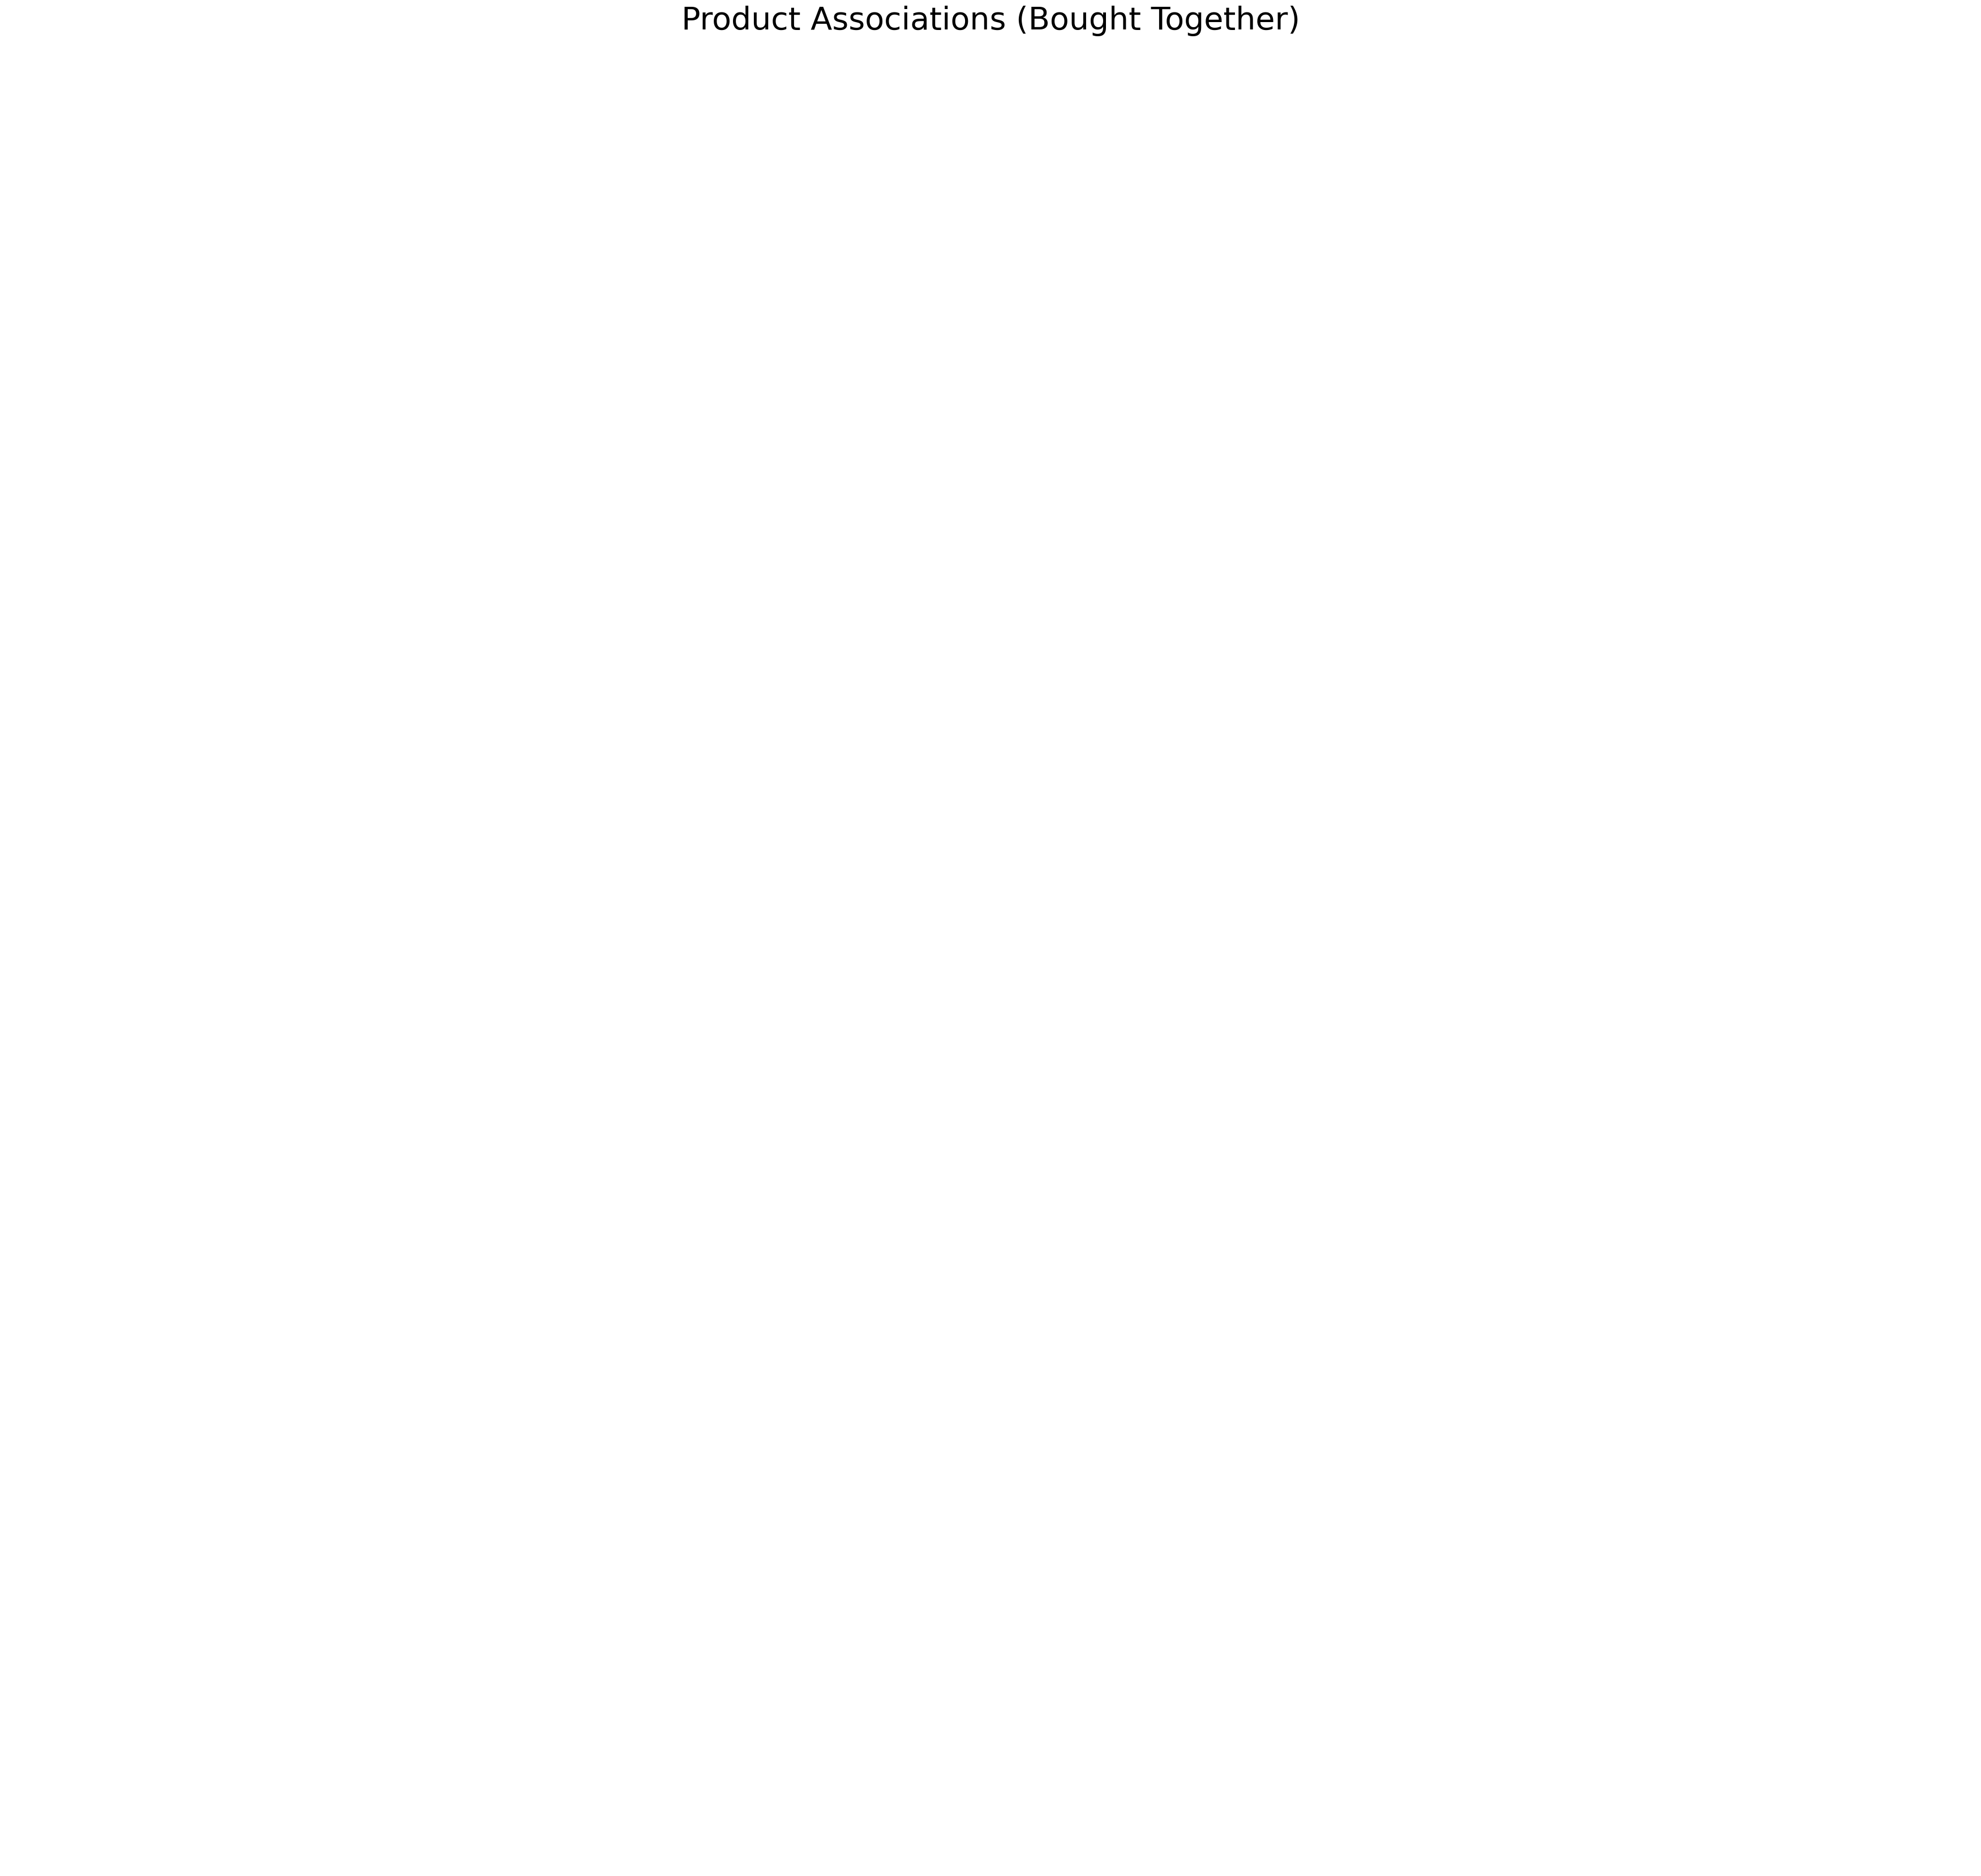

In [47]:

# Create an empty directed graph
G = nx.DiGraph()

# Add edges based on association rules
for _, rule in assoc_rules.iterrows():
    for antecedent in rule['antecedents']:
        for consequent in rule['consequents']:
            G.add_edge(antecedent, consequent, weight=rule['lift'])

# Plot the graph
plt.figure(figsize=(40,40),facecolor='white')

# Use spring_layout with additional iterations for better node separation
pos = nx.spring_layout(G, k=0.15, iterations=20)

# Draw the nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color="skyblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color=[G[u][v]['weight'] for u, v in G.edges()])
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", font_color="black")

# Add edge labels (showing lift values)
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Add a title
plt.title('Product Associations (Bought Together)', fontsize=40)

# Show the graph
plt.axis('off')  # Turn off the axis
plt.show()
